In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import os
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from scipy import stats
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import warnings
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pickle
import missingno as msno

warnings.filterwarnings('ignore')

SEED = 42
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
# Load datasets
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

## A. Handle the parquet time-series files: 

### 1. Define some Functions: 

In [26]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(),
    ]
    
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 22) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 7))
    no_mask = np.ones(len(df), dtype=bool)
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.diff().mean(), 
            data.diff().std()
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]


def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

def perform_pca(train, test, n_components=None, random_state=42):
    
    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

## 2. Load the data: 

In [43]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

# Standardize the data: 
scaler = StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

# Fill Nan with mean: 
for c in df_train.columns:
    m = np.mean(df_train[c])
    df_train[c].fillna(m, inplace=True)
    df_test[c].fillna(m, inplace=True)

print(df_train.shape)

#Apply PCA with 15 PCs: 
df_train_pca, df_test_pca, pca = perform_pca(df_train, df_test, n_components=15, random_state=SEED)

df_train_pca['id'] = train_ts['id']
df_test_pca['id'] = test_ts['id']

#Merge with the train dataset:
train = pd.merge(train, df_train_pca, how="left", on='id')
test = pd.merge(test, df_test_pca, how="left", on='id')

100%|██████████| 2/2 [00:00<00:00, 14.82it/s]


(996, 74)
Explained variance ratio of the components:
 [0.22219101 0.11409028 0.0661572  0.06115724 0.05273775 0.04588977
 0.04282018 0.0380403  0.03464054 0.02994127 0.02582855 0.02512205
 0.02316007 0.02173859 0.01984161]
0.8233563956394476


## B. Handle Train dataset:(after merge with time series file) 

In [28]:
print(train.shape)
print(test.shape)

(3960, 97)
(20, 74)


### 1. Cleaning Features: (Remove highly implausible values)

In [44]:
def clean_features(df):
    # Remove highly implausible values

    # Clip Grip
    df[['FGC-FGC_GSND', 'FGC-FGC_GSD']] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].clip(lower=9, upper=60)
    # Remove implausible body-fat
    df["BIA-BIA_Fat"] = np.where(df["BIA-BIA_Fat"] < 5, np.nan, df["BIA-BIA_Fat"])
    df["BIA-BIA_Fat"] = np.where(df["BIA-BIA_Fat"] > 60, np.nan, df["BIA-BIA_Fat"])
    # Basal Metabolic Rate
    df["BIA-BIA_BMR"] = np.where(df["BIA-BIA_BMR"] > 4000, np.nan, df["BIA-BIA_BMR"])
    # Daily Energy Expenditure
    df["BIA-BIA_DEE"] = np.where(df["BIA-BIA_DEE"] > 8000, np.nan, df["BIA-BIA_DEE"])
    # Bone Mineral Content
    df["BIA-BIA_BMC"] = np.where(df["BIA-BIA_BMC"] <= 0, np.nan, df["BIA-BIA_BMC"])
    df["BIA-BIA_BMC"] = np.where(df["BIA-BIA_BMC"] > 10, np.nan, df["BIA-BIA_BMC"])
    # Fat Free Mass Index
    df["BIA-BIA_FFM"] = np.where(df["BIA-BIA_FFM"] <= 0, np.nan, df["BIA-BIA_FFM"])
    df["BIA-BIA_FFM"] = np.where(df["BIA-BIA_FFM"] > 300, np.nan, df["BIA-BIA_FFM"])
    # Fat Mass Index
    df["BIA-BIA_FMI"] = np.where(df["BIA-BIA_FMI"] < 0, np.nan, df["BIA-BIA_FMI"])
    # Extra Cellular Water
    df["BIA-BIA_ECW"] = np.where(df["BIA-BIA_ECW"] > 100, np.nan, df["BIA-BIA_ECW"])
    # Intra Cellular Water
    # df["BIA-BIA_ICW"] = np.where(df["BIA-BIA_ICW"] > 100, np.nan, df["BIA-BIA_ICW"])
    # Lean Dry Mass
    df["BIA-BIA_LDM"] = np.where(df["BIA-BIA_LDM"] > 100, np.nan, df["BIA-BIA_LDM"])
    # Lean Soft Tissue
    df["BIA-BIA_LST"] = np.where(df["BIA-BIA_LST"] > 300, np.nan, df["BIA-BIA_LST"])
    # Skeletal Muscle Mass
    df["BIA-BIA_SMM"] = np.where(df["BIA-BIA_SMM"] > 300, np.nan, df["BIA-BIA_SMM"])
    # Total Body Water
    df["BIA-BIA_TBW"] = np.where(df["BIA-BIA_TBW"] > 300, np.nan, df["BIA-BIA_TBW"])
    
    return df

### 2. Feature Engineering: 

In [45]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    
    # From here on own features
    def assign_group(age):
        thresholds = [5, 6, 7, 8, 10, 12, 14, 17, 22]
        for i, j in enumerate(thresholds):
            if age <= j:
                return i
        return np.nan
    
    # Age groups
    df["group"] = df['Basic_Demos-Age'].apply(assign_group)
    
    # BMI 
    BMI_map = {0: 16.3,1: 15.9,2: 16.1,3: 16.8,4: 17.3,5: 19.2,6: 20.2,7: 22.3, 8: 23.6}
    df['BMI_mean_norm'] = df[['Physical-BMI', 'BIA-BIA_BMI']].mean(axis=1) / df["group"].map(BMI_map)
    
    # FGC zone aggregate
    zones = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
             'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
             'FGC-FGC_TL_Zone']
    
    df['FGC_Zones_mean'] = df[zones].mean(axis=1)
    df['FGC_Zones_min'] = df[zones].min(axis=1)
    df['FGC_Zones_max'] = df[zones].max(axis=1)
    
    # Grip
    GSD_max_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 16.2, 5: 19.9, 6: 26.1, 7: 31.3, 8: 35.4}
    GSD_min_map = {0: 9, 1: 9, 2: 9, 3: 9, 4: 14.4, 5: 17.8, 6: 23.4, 7: 27.8, 8: 31.1}
    
    df['GS_max'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].max(axis=1) / df["group"].map(GSD_max_map)
    df['GS_min'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].min(axis=1) / df["group"].map(GSD_min_map)
    
    # Curl-ups, push-ups, trunk-lifts... normalized based on age-group
    cu_map = {0: 1.0, 1: 3.0, 2: 5.0, 3: 7.0, 4: 10.0, 5: 14.0, 6: 20.0, 7: 20.0, 8: 20.0}
    pu_map = {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0, 5: 7.0, 6: 8.0, 7: 10.0, 8: 14.0}
    tl_map = {0: 8.0, 1: 8.0, 2: 8.0, 3: 9.0, 4: 9.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0}
    
    df["CU_norm"] = df['FGC-FGC_CU'] / df['group'].map(cu_map)
    df["PU_norm"] = df['FGC-FGC_PU'] / df['group'].map(pu_map)
    df["TL_norm"] = df['FGC-FGC_TL'] / df['group'].map(tl_map)
    
    # Reach 
    df["SR_min"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].min(axis=1)
    df["SR_max"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].max(axis=1)

    # BIA Features
    # Energy Expenditure
    bmr_map = {0: 934.0, 1: 941.0, 2: 999.0, 3: 1048.0, 4: 1283.0, 5: 1255.0, 6: 1481.0, 7: 1519.0, 8: 1650.0}
    dee_map = {0: 1471.0, 1: 1508.0, 2: 1640.0, 3: 1735.0, 4: 2132.0, 5: 2121.0, 6: 2528.0, 7: 2566.0, 8: 2793.0}
    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["group"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["group"].map(dee_map)
    df["DEE_BMR"] = df["BIA-BIA_DEE"] - df["BIA-BIA_BMR"]

    # FMM
    ffm_map = {0: 42.0, 1: 43.0, 2: 49.0, 3: 54.0, 4: 60.0, 5: 76.0, 6: 94.0, 7: 104.0, 8: 111.0}
    df["FFM_norm"] = df["BIA-BIA_FFM"] / df["group"].map(ffm_map)

    # ECW ICW
    df["ICW_ECW"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]
    
    drop_feats = ['FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
                  'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
                  'Physical-BMI', 'BIA-BIA_BMI', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'FGC-FGC_SRL', 'FGC-FGC_SRR',
                 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_Frame_num', "BIA-BIA_FFM"]
    df = df.drop(drop_feats, axis=1) 
    return df

In [46]:
train = clean_features(train)
train = feature_engineering(train)

test = clean_features(test)
test = feature_engineering(test)

In [47]:
def bin_data(train, test, columns, n_bins=10):
    # Combine train and test for consistent bin edges
    combined = pd.concat([train, test], axis=0)
    
    bin_edges = {}
    for col in columns:
        # Compute quantile bin edges
        edges = pd.qcut(combined[col], n_bins, retbins=True, labels=range(n_bins), duplicates="drop")[1]
        bin_edges[col] = edges
    
    # Apply the same bin edges to both train and test
    for col, edges in bin_edges.items():
        train[col] = pd.cut(
            train[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)
        test[col] = pd.cut(
            test[col], bins=edges, labels=range(len(edges) - 1), include_lowest=True
        ).astype(float)
    
    return train, test

# Usage example
columns_to_bin = [
    "PAQ_A-PAQ_A_Total", "BMR_norm", "DEE_norm", "GS_min", "GS_max", "BIA-BIA_FFMI", 
    "BIA-BIA_BMC", "Physical-HeartRate", "BIA-BIA_ICW", "Fitness_Endurance-Time_Sec", 
    "BIA-BIA_LDM", "BIA-BIA_SMM", "BIA-BIA_TBW", "DEE_BMR", "ICW_ECW"
]
train, test = bin_data(train, test, columns_to_bin, n_bins=10)

In [48]:
exclude = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition
features = [f for f in train.columns if f not in exclude]

# Categorical features
# cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
#           'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']
cat_c = []

for col in cat_c:
    a_map = {}
    all_unique = set(train[col].unique()) | set(test[col].unique())
    for i, value in enumerate(all_unique):
        a_map[value] = i

    train[col] = train[col].map(a_map)
    test[col] = test[col].map(a_map)
    
train = train[train["sii"].notna()] # Keep rows where target is available
train.shape

(2736, 83)

<Axes: >

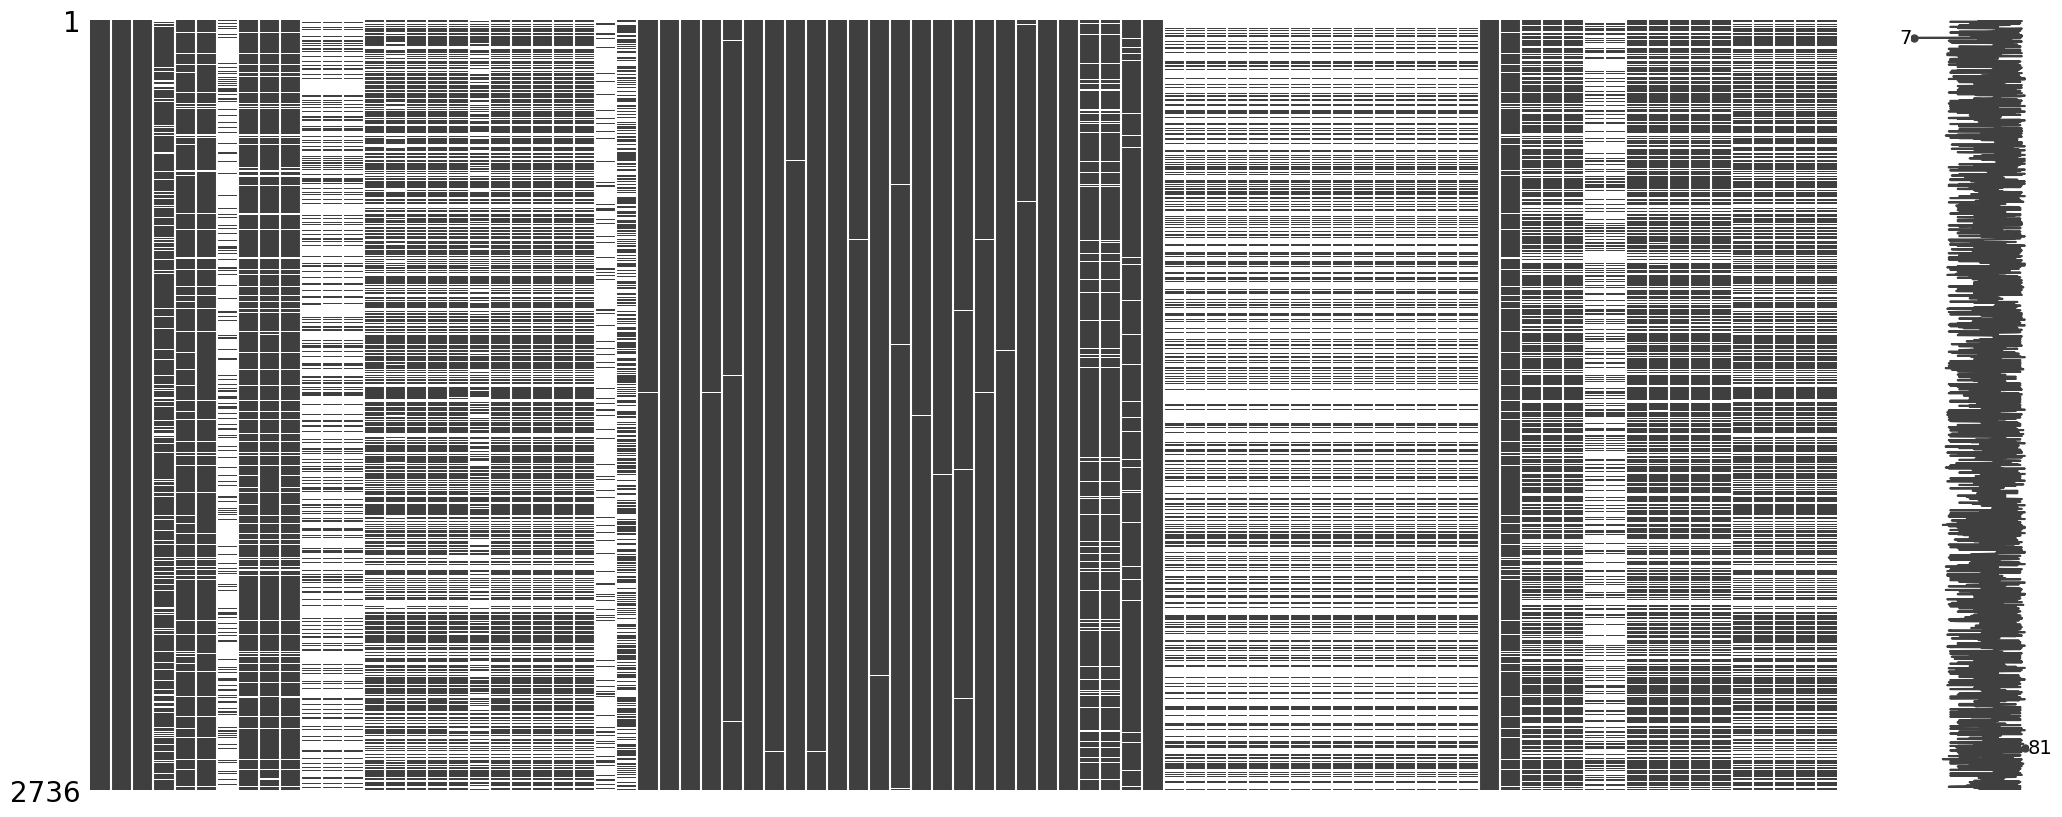

In [49]:
#Check missing values: 
msno.matrix(train)

In [33]:
train.head(3)

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,CU_norm,PU_norm,TL_norm,SR_min,SR_max,BMR_norm,DEE_norm,DEE_BMR,FFM_norm,ICW_ECW
0,00008ff9,5,0,51.0,46.0,50.8,NaN,NaN,NaN,NaN,...,0.0,0.0,0.750000,6.0,7.0,0.998392,1.014276,559.502,0.990148,0.337877
1,000fd460,9,0,NaN,48.0,46.0,22.0,75.0,70.0,122.0,...,0.3,1.0,0.333333,11.0,11.0,0.730051,0.702932,561.994,0.700485,0.286184
2,00105258,10,1,71.0,56.5,75.6,NaN,65.0,94.0,117.0,...,2.0,1.4,0.555556,10.0,10.0,NaN,NaN,NaN,NaN,NaN


### 3. Impute missing values: 

In [50]:
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [51]:

model = LassoCV(cv=5, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer.fit_models(model, train, features)
train = imputer.impute(train)
# test = imputer.impute(test)

100%|██████████| 60/60 [00:07<00:00,  8.27it/s]


<Axes: >

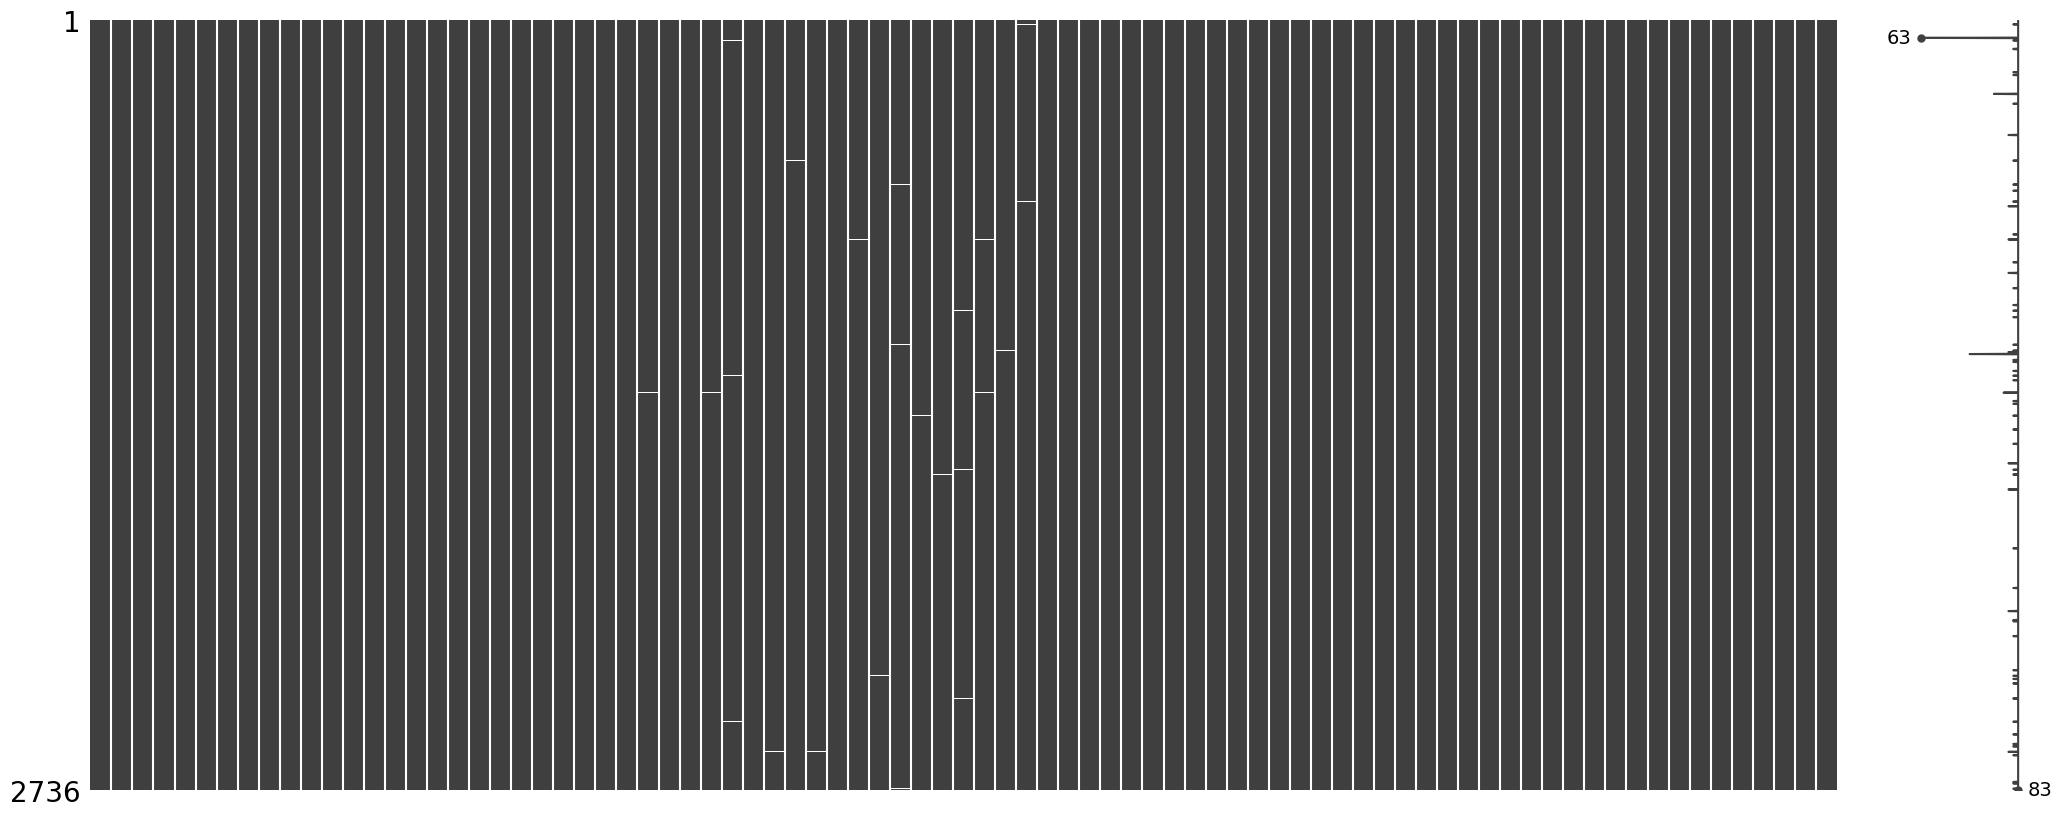

In [52]:
msno.matrix(train)